The current device is cpu


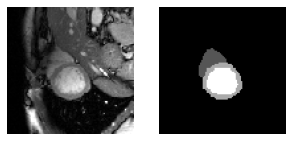

AttributeError: 'numpy.float64' object has no attribute 'backward'

In [35]:
import torch 
import torch.utils.data as data 
import cv2 
import os
from glob import glob 
import numpy as np 
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import DataLoader 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable 

# Finds the device the data will be computed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

# Create variables which stores the location of the training images and validation images.
train_data_path = './data/train'

val_data_path = './data/val'

# It visualises the actual MR image and its mask.
def show_image_mask(img, mask, cmap='gray'): 
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    
#image = cv2.imread(os.path.join(folder_data_train,'image','cmr10.png'), cv2.IMREAD_UNCHANGED) # A random image to find later the size of it.
#mask = cv2.imread(os.path.join(folder_data_train,'mask','cmr10_mask.png'), cv2.IMREAD_UNCHANGED)
#show_image_mask(image, mask, cmap='gray')
#plt.pause(1)
#cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)


# It loads all the images for the training files.
class CustomDataset(data.Dataset):
    def __init__(self, root=''):
        super(CustomDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)
    

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


# Since every image is black and white, they have depth 1. So the unedit image has a weight and heigh 96 and depth 1.
# So we need the output to have channel 4.

# The model is the encode of a combination of the image in the CNN power point pg78 and the figure 5 of 
# https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
# First of all, the model will take an image with size 96x96 with depth 4, it will be convoluted to a matrix of size 48x48 with depht 32 using 
# max pooling, again it will be convoluted to a new matrix of size 24x24 with depht 64 using max pooling, again it will be convoluted 
# to a matrix of size 12x12 with depht 128 using max pooling. Then, the last matrix will be convoluted to a matrix
# of size 24x24 with depth 64 using max unpooling, it will be convoluted to matrix of size 48x48 with depth 32 using
# max unpooling and it will be convoluted to a matrix of size 96x96 with depht 4 using max unpooling. So, first it pools
# the matrix and then unpool the matrix to give back the same size. 

class CNNSEG(nn.Module): # Define your model
    def __init__(self):
        super(CNNSEG, self).__init__()
        self.conv1 = nn.Conv2d(4,16,3,padding=1) # The convolution which takes 4 channel and gives back 32 channels.
        self.conv2 = nn.Conv2d(16,64,3,padding=1) # The convolution which takes 32 channel and gives back 64 channels.
        self.conv3 = nn.Conv2d(64,128,3,padding=1) # The convolution which takes 64 channel and gives back 128 channels.
        self.unconv1 = nn.Conv2d(128,64,3,padding=1) # The convolution which takes 128 channel and gives back 64 channels.
        self.unconv2 = nn.Conv2d(64,16,3,padding=1) # The convolution which takes 64 channel and gives back 32 channels.
        self.unconv3 = nn.Conv2d(16,4,3,padding=1) # The convolution which takes 32 channel and gives back 4 channels.
        self.pool = nn.MaxPool2d(2,2,return_indices=True) # A 2x2 max pooling, we need the indices from the pooling so it is True.https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        self.unpool = nn.MaxUnpool2d(2,2) # A 2x2 max unpooling. #https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html

    def forward(self, x):
        x , ind1 = self.pool(F.relu(self.conv1(x)))
        x , ind2 = self.pool(F.relu(self.conv2(x)))
        x , ind3 = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.unconv1(self.unpool(x,ind3)))
        x = F.relu(self.unconv2(self.unpool(x,ind2)))
        x = F.relu(self.unconv3(self.unpool(x,ind1)))
        return x

model = CNNSEG()


def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

#For Loss function I use the dice score.
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9)

num_workers = 4

batch_size = 4

# Saves all the images in the variables train_set and valid_set.
train_set = CustomDataset(train_data_path)
valid_set = CustomDataset(val_data_path)

# train_set = CustomDataset(folder_mask_train)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

# test_set = CustomDataset(folder_data_val)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

for iteration, sample in enumerate(training_data_loader):
    img, mask = sample
    
    show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
    plt.pause(1)
    
    # Make the input images, output masks and predicted output to be all channel 4. The predicted masks will be channel 4.
    im = img.unsqueeze(1) # To put the dimension of the channel in the second place of the image. https://discuss.pytorch.org/t/change-the-dimension-of-tensor/51459/7
    im_c4 = []
    im_c4 = torch.from_numpy(np.concatenate((im,)*4, axis=1)) # https://stackoverflow.com/questions/40119743/convert-a-grayscale-image-to-a-3-channel-image
    
    ma = mask.unsqueeze(1)
    ma_c4 = torch.from_numpy(np.concatenate((ma,)*4, axis=1))
    mask1 = ma_c4.numpy()
    # The optimised gradients set to zero. https://pytorch.org/docs/stable/optim.html
    optimizer.zero_grad()

    mask_pr = model(im_c4) # Returns the predicted mask. Forward probacation
    mask2 = ma_c4.numpy()
    # Calculate the cross entropy loss for the predicted mask and the actual mask.
    loss_m = categorical_dice(mask1,mask2,1) 
    loss_m.backward() # Backward probacation
    optimizer.step()
    

